<a href="https://colab.research.google.com/github/Vamshi-Nallaguntla/BeeHive-Audio-Generalization/blob/main/TBON(Train)_NuHive(Test)_CNN_BI_LSTM_Implicit_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install keras-tuner
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
# Step 1: Import Libraries
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.fft import fft
from scipy.linalg import sqrtm
from scipy.signal import fftconvolve

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Define Dataset Paths
tbon_queen_folder = "/content/drive/My Drive/BeeHive/Datasets/TBON_Processed_Organized/Queen"
tbon_noqueen_folder = "/content/drive/My Drive/BeeHive/Datasets/TBON_Processed_Organized/No_Queen"
nuhive_hive1_queen = "/content/drive/My Drive/BeeHive/Datasets/NuHive/Hive1_12_06_2018"
nuhive_hive1_noqueen = "/content/drive/My Drive/BeeHive/Datasets/NuHive/Hive1_31_05_2018"
nuhive_hive3_queen = "/content/drive/My Drive/BeeHive/Datasets/NuHive/Hive3_28_07_2017"
nuhive_hive3_noqueen = "/content/drive/My Drive/BeeHive/Datasets/NuHive/Hive3_14_07_2017"

In [ ]:
# Step 3: Define Preprocessing with Data Augmentation
def add_gaussian_noise(mel_spec, noise_factor=0.005):
    """Add Gaussian noise to the Mel-Spectrogram."""
    noise = np.random.normal(0, noise_factor, mel_spec.shape)
    return mel_spec + noise

def frequency_mask(mel_spec, max_percentage=0.05):
    """Apply frequency masking to the Mel-Spectrogram."""
    num_freqs = mel_spec.shape[0]
    mask_width = int(num_freqs * max_percentage)
    mask_start = np.random.randint(0, num_freqs - mask_width)
    mel_spec[mask_start:mask_start + mask_width, :] = 0
    return mel_spec

def time_mask(mel_spec, max_percentage=0.15):
    """Apply time masking to the Mel-Spectrogram."""
    num_timesteps = mel_spec.shape[1]
    mask_width = int(num_timesteps * max_percentage)
    mask_start = np.random.randint(0, num_timesteps - mask_width)
    mel_spec[:, mask_start:mask_start + mask_width] = 0
    return mel_spec

def amplitude_perturbation(mel_spec, perturbation_factor=0.1):
    """Apply amplitude perturbation to the Mel-Spectrogram."""
    scale = np.random.uniform(1 - perturbation_factor, 1 + perturbation_factor)
    return mel_spec * scale

def preprocess_audio_with_augmentation(folder, label, sr=16000, n_mfcc=13, augment=False):
    features, labels = [], []
    for file_name in os.listdir(folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder, file_name)
            try:
                y, sr = librosa.load(file_path, sr=sr)
                y = librosa.util.fix_length(y, size=int(2 * sr))  # 2-second audio
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
                mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), sr=sr, n_mfcc=n_mfcc)
                features.append(np.mean(mfcc, axis=1))
                labels.append(label)

                if augment:
                    # Apply sequential augmentations
                    for _ in range(3):  # Creates 3 augmented versions per sample
                        # Step 1: Gaussian noise
                        mel_aug = add_gaussian_noise(mel_spec)

                        # Step 2: Spectral augmentations (frequency and time masking)
                        mel_aug = frequency_mask(mel_aug)
                        mel_aug = time_mask(mel_aug)

                        # Step 3: Amplitude perturbation
                        mel_aug = amplitude_perturbation(mel_aug)

                        # Convert augmented Mel-Spectrogram back to MFCC
                        mfcc_aug = librosa.feature.mfcc(S=librosa.power_to_db(mel_aug), sr=sr, n_mfcc=n_mfcc)
                        features.append(np.mean(mfcc_aug, axis=1))
                        labels.append(label)

                    # Apply pitch shifting
                    for step in [-2, -1, 1, 2]:
                        y_pitch_shifted = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=step)
                        mel_pitch_shifted = librosa.feature.melspectrogram(y=y_pitch_shifted, sr=sr, n_mels=64)
                        mfcc_pitch_shifted = librosa.feature.mfcc(S=librosa.power_to_db(mel_pitch_shifted), sr=sr, n_mfcc=n_mfcc)
                        features.append(np.mean(mfcc_pitch_shifted, axis=1))
                        labels.append(label)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    return np.array(features), np.array(labels)

# Preprocess TBON Dataset
X_tbon_queen, y_tbon_queen = preprocess_audio_with_augmentation(tbon_queen_folder, label=1, augment=True)
X_tbon_noqueen, y_tbon_noqueen = preprocess_audio_with_augmentation(tbon_noqueen_folder, label=0, augment=True)
X_tbon = np.concatenate([X_tbon_queen, X_tbon_noqueen], axis=0)
y_tbon = np.concatenate([y_tbon_queen, y_tbon_noqueen], axis=0)

# Preprocess NuHive Dataset
def preprocess_nuhive():
    X_hive1_queen, y_hive1_queen = preprocess_audio_with_augmentation(nuhive_hive1_queen, label=1)
    X_hive1_noqueen, y_hive1_noqueen = preprocess_audio_with_augmentation(nuhive_hive1_noqueen, label=0)
    X_hive1 = np.concatenate([X_hive1_queen, X_hive1_noqueen], axis=0)
    y_hive1 = np.concatenate([y_hive1_queen, y_hive1_noqueen], axis=0)

    X_hive3_queen, y_hive3_queen = preprocess_audio_with_augmentation(nuhive_hive3_queen, label=1)
    X_hive3_noqueen, y_hive3_noqueen = preprocess_audio_with_augmentation(nuhive_hive3_noqueen, label=0)
    X_hive3 = np.concatenate([X_hive3_queen, X_hive3_noqueen], axis=0)
    y_hive3 = np.concatenate([y_hive3_queen, y_hive3_noqueen], axis=0)

    X_nuhive_full = np.concatenate([X_hive1, X_hive3], axis=0)
    y_nuhive_full = np.concatenate([y_hive1, y_hive3], axis=0)

    return X_hive1, y_hive1, X_hive3, y_hive3, X_nuhive_full, y_nuhive_full

X_hive1, y_hive1, X_hive3, y_hive3, X_nuhive_full, y_nuhive_full = preprocess_nuhive()

In [ ]:
# Step 4: Normalize Features
scaler = StandardScaler()
X_tbon = scaler.fit_transform(X_tbon)
X_hive1 = scaler.transform(X_hive1)
X_hive3 = scaler.transform(X_hive3)
X_nuhive_full = scaler.transform(X_nuhive_full)

# Reshape Data for CNN-BI-LSTM
X_tbon = X_tbon.reshape(-1, 13, 1, 1)
X_hive1 = X_hive1.reshape(-1, 13, 1, 1)
X_hive3 = X_hive3.reshape(-1, 13, 1, 1)
X_nuhive_full = X_nuhive_full.reshape(-1, 13, 1, 1)


In [ ]:
# Step 5: Hyperparameter Tuning with Keras Tuner
def model_builder(hp):
    model = Sequential()

    # Add Input Layer
    input_shape = (13, 1, 1)
    model.add(Conv2D(hp.Choice('filters_0', [32, 64, 128]), (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # CNN Layers (Number of layers tuned)
    for i in range(1, hp.Int('num_cnn_layers', 4, 6)):
        model.add(Conv2D(hp.Choice(f'filters_{i}', [32, 64, 128]), (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), padding='same'))

    # Reshape for BI-LSTM Input
    cnn_output_shape = model.output_shape  # (batch_size, height, width, channels)
    reshape_dim = (cnn_output_shape[1] * cnn_output_shape[2], cnn_output_shape[3])
    model.add(Reshape(reshape_dim))

    # BI-LSTM Layers (Number of layers tuned)
    for i in range(hp.Int('num_lstm_layers', 1, 3)):  # 1 to 3 BI-LSTM layers
        model.add(Bidirectional(
            LSTM(
                hp.Choice(f'lstm_units_{i}', [32, 64, 128]),
                return_sequences=(i < hp.Int('num_lstm_layers', 1, 3) - 1)
            )
        ))
        model.add(Dropout(hp.Choice(f'dropout_{i}', [0.2, 0.3, 0.5])))

    # Dense Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile Model
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=15,
    directory='tuning_dir',
    project_name='cnn_bilstm_tuning_layers'
)

# Train-Test Split for Tuning
X_train, X_val, y_train, y_val = train_test_split(X_tbon, y_tbon, test_size=0.2, random_state=42)

# Hyperparameter Search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print Best Hyperparameters
print("Best Hyperparameters:")
print(f"Number of CNN Layers: {best_hps.get('num_cnn_layers')}")
for i in range(best_hps.get('num_cnn_layers')):
    print(f"Filters for Conv2D Layer {i+1}: {best_hps.get(f'filters_{i}')}")

print(f"Number of BI-LSTM Layers: {best_hps.get('num_lstm_layers')}")
for i in range(best_hps.get('num_lstm_layers')):
    print(f"LSTM Units for Layer {i+1}: {best_hps.get(f'lstm_units_{i}')}")
    print(f"Dropout for Layer {i+1}: {best_hps.get(f'dropout_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


Trial 15 Complete [00h 15m 32s]
val_accuracy: 0.9990818500518799

Best val_accuracy So Far: 0.9992349147796631
Total elapsed time: 03h 31m 20s
Best Hyperparameters:
Number of CNN Layers: 6
Filters for Conv2D Layer 1: 32
Filters for Conv2D Layer 2: 128
Filters for Conv2D Layer 3: 64
Filters for Conv2D Layer 4: 128
Filters for Conv2D Layer 5: 32
Filters for Conv2D Layer 6: 64
Number of BI-LSTM Layers: 3
LSTM Units for Layer 1: 64
Dropout for Layer 1: 0.3
LSTM Units for Layer 2: 32
Dropout for Layer 2: 0.2
LSTM Units for Layer 3: 128
Dropout for Layer 3: 0.5
Learning Rate: 0.001


In [ ]:
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")


Best Hyperparameters:
filters_0: 32
num_cnn_layers: 6
filters_1: 128
filters_2: 64
filters_3: 128
num_lstm_layers: 3
lstm_units_0: 64
dropout_0: 0.3
learning_rate: 0.001
filters_4: 32
lstm_units_1: 32
dropout_1: 0.2
filters_5: 64
lstm_units_2: 128
dropout_2: 0.5


In [ ]:
# Build and Train Final Model
final_model = tuner.hypermodel.build(best_hps)
history = final_model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9284 - loss: 0.2055
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9948 - loss: 0.0251
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9950 - loss: 0.0224
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9949 - loss: 0.0213
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9951 - loss: 0.0191
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9969 - loss: 0.0120
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9969 - loss: 0.0144
Epoch 8/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9967 - loss: 0.0109
Epoch 9/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9973 - loss: 0.0108
Epoch 10/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9972 - loss: 0.0100
Epoch 11/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9971 - loss: 0.0123
Epoch 12/100
817/81

In [ ]:
# Step 6: Evaluate and Visualize Results
print("Hive 1 Results:")
hive1_results = final_model.evaluate(X_hive1, y_hive1, verbose=0)
print("Hive 3 Results:")
hive3_results = final_model.evaluate(X_hive3, y_hive3, verbose=0)
print("Entire NuHive Results:")
nuhive_results = final_model.evaluate(X_nuhive_full, y_nuhive_full, verbose=0)

# Classification Report for Hive 1
y_pred = (final_model.predict(X_hive1) > 0.5).astype(int)
print("Hive 1 Classification Report:")
print(classification_report(y_hive1, y_pred))

Hive 1 Results:
Hive 3 Results:
Entire NuHive Results:
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
Hive 1 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.04      0.08       144
           1       0.49      0.94      0.65       144

    accuracy                           0.49       288
   macro avg       0.45      0.49      0.36       288
weighted avg       0.45      0.49      0.36       288



In [ ]:
# Classification Report for Hive 3
y_pred = (final_model.predict(X_hive3) > 0.5).astype(int)
print("Hive 3 Classification Report:")
print(classification_report(y_hive3, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Hive 3 Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.01      0.02       144
           1       0.46      0.83      0.59       144

    accuracy                           0.42       288
   macro avg       0.27      0.42      0.31       288
weighted avg       0.27      0.42      0.31       288



In [ ]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=["No Queen", "Queen"], yticklabels=["No Queen", "Queen"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


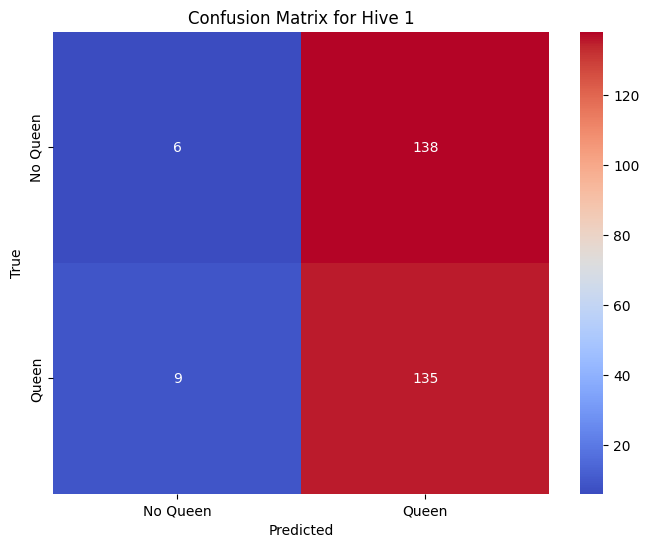

In [ ]:
# Hive 1 Confusion Matrix
y_pred_hive1 = (final_model.predict(X_hive1) > 0.5).astype(int)
plot_confusion_matrix(y_hive1, y_pred_hive1, "Confusion Matrix for Hive 1")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


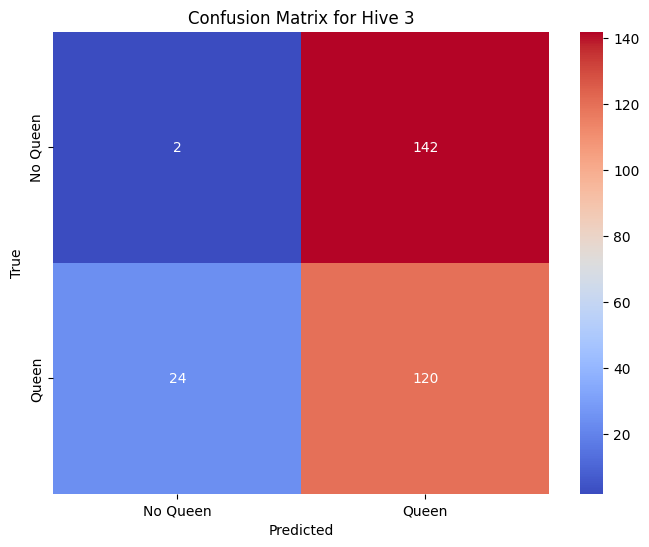

In [ ]:
# Hive 3 Confusion Matrix
y_pred_hive3 = (final_model.predict(X_hive3) > 0.5).astype(int)
plot_confusion_matrix(y_hive3, y_pred_hive3, "Confusion Matrix for Hive 3")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


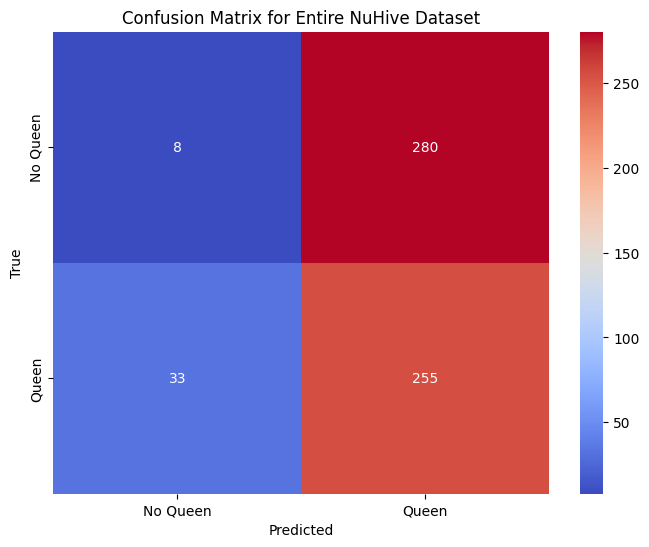

In [ ]:
# Entire NuHive Dataset Confusion Matrix
y_pred_nuhive = (final_model.predict(X_nuhive_full) > 0.5).astype(int)
plot_confusion_matrix(y_nuhive_full, y_pred_nuhive, "Confusion Matrix for Entire NuHive Dataset")

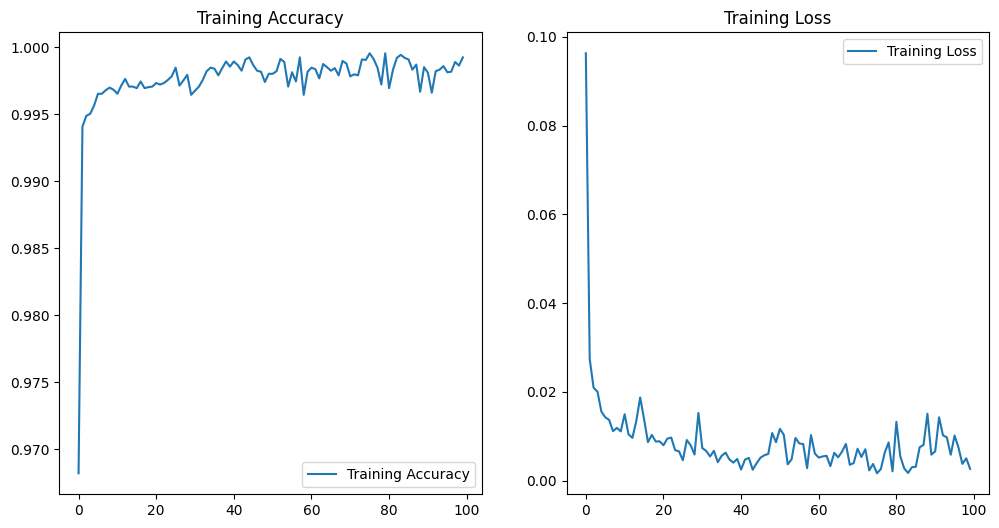

In [ ]:
# Training plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

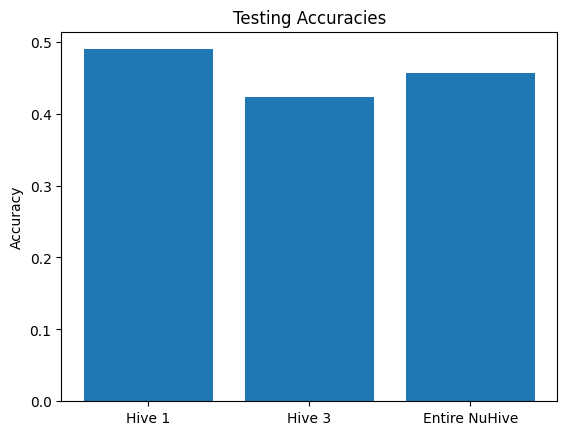

In [ ]:
# Testing Metrics
testing_metrics = ['Hive 1', 'Hive 3', 'Entire NuHive']
testing_accuracies = [hive1_results[1], hive3_results[1], nuhive_results[1]]

plt.bar(testing_metrics, testing_accuracies)
plt.title('Testing Accuracies')
plt.ylabel('Accuracy')
plt.show()